#Sanity Checks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

In [ ]:
from masks import grad_cam
from masks.meanpertrub import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints/'
isTrain = True

In [ ]:
X = np.load('/home/datasets/adni/tensors_cut.npz')
y = np.load('/home/datasets/adni/labels.npy')

In [ ]:
X = X.f.arr_0

In [ ]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
#         sample = {'img': self.X[idx], 'landmarks': self.y[idx]}
#         if self.transform:
#                    sample = self.transform(sample)
        return self.X[idx], self.y[idx]

In [ ]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=4*c*5*5*5, out_features=2),
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:1")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [1]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

In [ ]:
dataset = MriData(X, y, transform=None)

In [ ]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

Model Randomization Test

GradCam

In [13]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    i = 0
    for  name, param in model.module.named_parameters():
        if param.requires_grad:
            if 'weight' in name:
                print('masks for', name)
                param.data = param.data[torch.randperm(param.data.size()[0])]
                if i ==4:
                    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam')
                    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_'+name), masks_grad)
                    break
                i +=1
else:
    masks_grad = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam.npy'))

  0%|          | 0/517 [00:00<?, ?it/s]

masks for features.0.weight
masks for features.1.weight
masks for features.4.weight
masks for features.5.weight
masks for features.8.weight


100%|██████████| 517/517 [01:34<00:00,  5.47it/s]


In [13]:
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))

In [12]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

/usr/local/lib/python3.6/dist-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/.local/lib/python3.6/site-packages/numpy/ma/core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


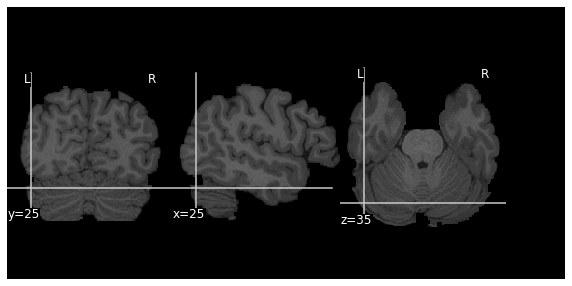

In [14]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.2)
plt.show()
# fig.savefig("grad_cam.png", bbox_inches='tight')

In [16]:
for  name, param in model.module.named_parameters():
    if param.requires_grad:
        if 'weight' in name:
            print(name)
#             print(param.data[0])
#             print(type(param.data))
#             weight_sh = param.data[torch.randperm(param.data.size()[0])]
#             print(weight_sh[0])
#             print(param.data[0])
            

features.0.weight
features.1.weight
features.4.weight
features.5.weight
features.8.weight
features.9.weight
classifier.2.weight


Guided Back-propagation

In [10]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    i = 0
    for  name, param in model.module.named_parameters():
        if param.requires_grad:
            if 'weight' in name:
                print('masks for', name)
                param.data = param.data[torch.randperm(param.data.size()[0])]
                if i ==2:
                    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
                    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb' + name), masks_gb)
                    break
                i +=1
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))


  0%|          | 0/517 [00:00<?, ?it/s]

masks for features.0.weight
masks for features.1.weight
masks for features.4.weight


100%|██████████| 517/517 [08:47<00:00,  1.02s/it]


In [10]:
masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gbfeatures.0.weight.npy'))

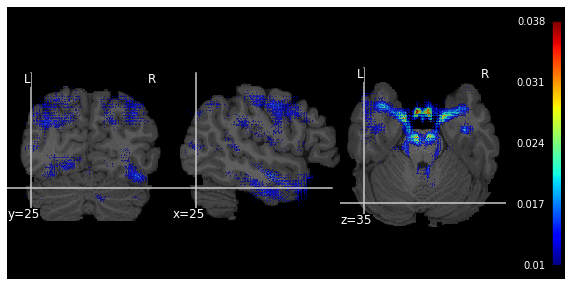

In [11]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
# fig.savefig("guided backpropagation.png", bbox_inches='tight')